# Exploring New Alloy Systems with Pymatgen

#### Author: Rachel Woods-Robinson
#### Version: July 29, 2020


<img src="assets/goals.png" style="max-width:50%">

## Outline

1. Select a test-case system
    * 1.1 Exercise: `Structure` and `MPRester` refresher
    * 1.2 Lesson: add oxidation states to a `Structure`
2. Select an alloy partner
    * 2.1 Lesson: find possible dopants
    * 2.2 Exercise: find the best alloy partner (A = ?) for A<sub>x</sub>Zn<sub>1-x</sub>S
    * 2.3 Lesson: explore phase diagrams
3. Transform to make a new Cu<sub>x</sub>Zn<sub>1-x</sub>S alloy
    * 3.1 Lesson: structure transformation
    * 3.2 Exercise: try your own transformation on CuZnS<sub>2</sub>
4. Calculate new properties
    * 4.1 Lesson: volume prediction and XRD plot
    * 4.2 Exercise: try this on your CuZnS<sub>2</sub> structure
5. Test your skills
    * 5.1 Exercise: compare relaxed DFT structures to estimates
    * 5.2 Lesson: add computed entries to phase diagram
    * 5.3 Next steps

## 1. Select a test-case system

***In this notebook we will focus on cubic zinc-blende ZnS, a wide band gap (transparent) semiconductor. In my PhD research I study p-type transparent semiconductors, so I will pose the question: how can we use ZnS as a starting point to create a p-type transparent semiconductor, and how can pymatgen help with this?***

Import the `MPRester` API:

In [9]:
from pymatgen import MPRester

The Materials ID (mp-id) of zinc-blende ZnS is mp-10695, see https://materialsproject.org/materials/mp-10695/.

In [10]:
ZnS_mpid = "mp-10695"

### 1.1 Exercise: `Structure` and `MPRester` refresher

#### Get the structure

In [13]:
with MPRester() as mpr: # YOUR API KEY GOES IN THIS FUNCTION! copy from materialsproject.org/dashboard
    ZnS_structure = mpr.get_structure_by_material_id(ZnS_mpid)

In [14]:
#### if you're having problems with your internet or API key:

# from monty.serialization import loadfn
# ZnS_structure = loadfn("assets/ZnS_structure.json")

#### Get space group information

In [15]:
ZnS_structure.get_space_group_info()

('F-43m', 216)

If you want to, try it out on our web app [here](https://materialsproject.org/#apps/xtaltoolkit/%7B%22input%22%3A0%2C%22materialIDs%22%3A%22mp-10695%22%7D).

- Click "Draw atoms outside unit cell bonded to atoms within unit cell"
- Play around with it!

<img src="assets/ZnS_F-43m_MP.png" style="max-width:50%">

### 1.2 Lesson: add oxidation states to a `Structure`

Pymatgen has a simple transformation to estimate the likely oxidation state of each specie in stoichiometric compounds using a bond-valence analysis approach. This information is needed to compare ionic radii and assess substitutional dopant probability. You can also enter the oxidation states manually if you'd prefer.

In [19]:
from pymatgen.transformations.standard_transformations import AutoOxiStateDecorationTransformation

Initialize this transformation:

In [20]:
oxi_transformation = AutoOxiStateDecorationTransformation()

In [21]:
ZnS_structure_oxi = oxi_transformation.apply_transformation(ZnS_structure)

In [22]:
print(ZnS_structure_oxi)

Full Formula (Zn1 S1)
Reduced Formula: ZnS
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c    magmom
---  ----  ----  ----  ----  --------
  0  Zn2+  0     0     0            0
  1  S2-   0.25  0.25  0.25        -0


### 1.3 Bonus: plot a band structure retrieved from Materials Project

In [23]:
from pymatgen.electronic_structure.plotter import BSPlotter

This code retrieves a `BandStructureSymmLine` object which contains all the information about a line-mode band structure.

In [24]:
with MPRester() as mpr: # YOUR API KEY GOES IN THIS FUNCTION! copy from materialsproject.org/dashboard
    ZnS_bs = mpr.get_bandstructure_by_material_id(ZnS_mpid)

In [ ]:
#### if you're having problems with your internet or API key

# from monty.serialization import loadfn
# ZnS_bs = loadfn("assets/ZnS_bs.json")

This band structure can be plotted using `BSPlotter`:

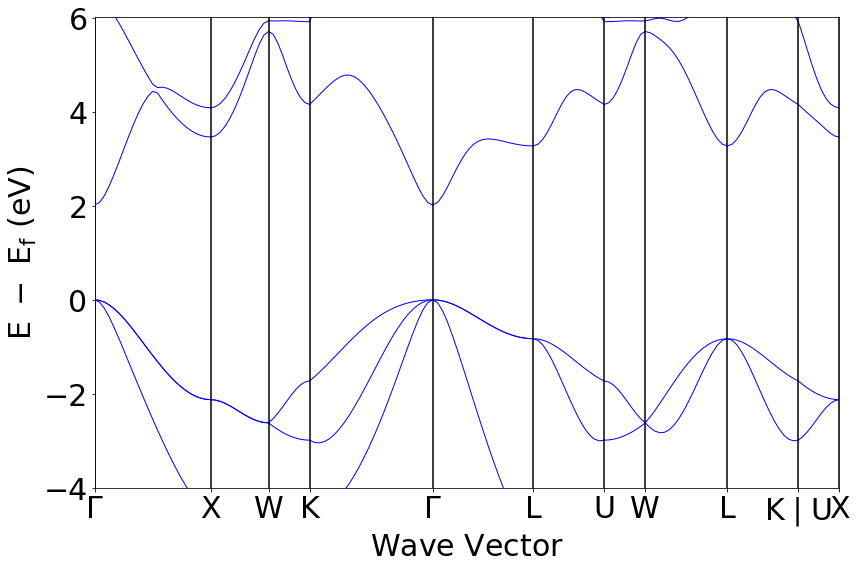

In [26]:
ZnS_bsp = BSPlotter(ZnS_bs)
ZnS_bsp.show() # takes a second

#### Band gap correction

In [27]:
ZnS_bs.get_band_gap()

{'direct': True, 'energy': 2.0186, 'transition': '\\Gamma-\\Gamma'}

ZnS has an experimental gap of approximately 3.5 eV, but the GGA calculated gap is far too low! We can apply a "scissor" to this band structure to correct for this.

Scissor corrections are only appropriate if they're clearly acknowledged! They're used here because we expect the shape of the bands to be correct from our GGA calculation, and we know experimentally the gap is 3.5 eV. We do not use any scissor corrections on the Materials Project website or in the database.

In [34]:
ZnS_bs_scissor = ZnS_bs.apply_scissor(new_band_gap=3.5)

In [35]:
ZnS_bsp_scissor = BSPlotter(ZnS_bs_scissor)

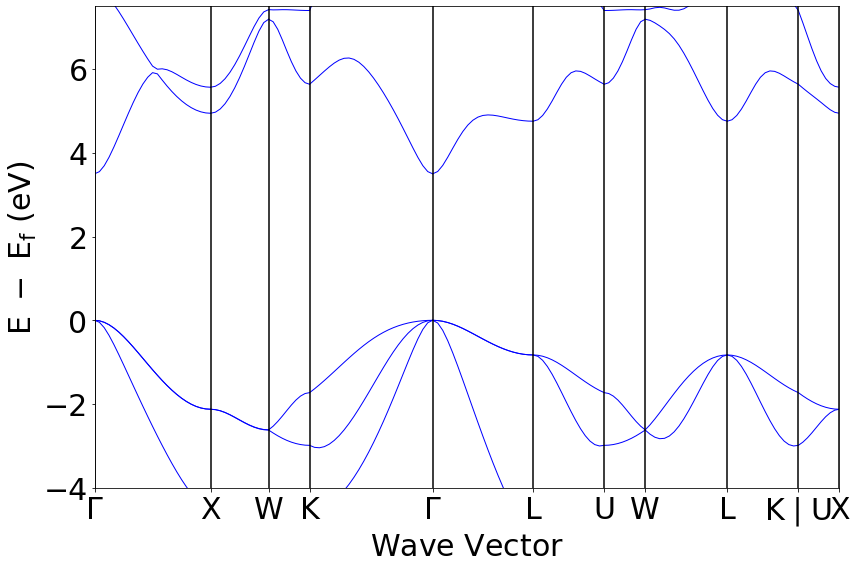

In [36]:
ZnS_bsp_scissor.show()

## 2. Select an alloy partner

### 2.1 Lesson: find possible dopants

***Scientific question: Which p-type dopants are most likely to sit at substitutional sites in ZnS?***

Pymatgen has a machine-learned method for estimating the probability that one ion will substitute for another ([Hautier et al. 2011](https://doi.org/10.1021/ic102031h)), and reports the results ranked in order of probability. Note the input structure has to be "decorated" with oxidation states for this method to work.

In [37]:
from pymatgen.analysis.structure_prediction.dopant_predictor import get_dopants_from_substitution_probabilities

In [57]:
substitutional_dopants = get_dopants_from_substitution_probabilities(
    ZnS_structure_oxi, num_dopants=10)

Here are some options to dope ZnS p-type:

In [58]:
p_dopants = substitutional_dopants['p_type']

We can see this returns a list of dictionaries:

In [59]:
print(p_dopants)

[{'probability': 0.03517771488410048, 'dopant_species': Specie Na+, 'original_species': Specie Zn2+}, {'probability': 0.029318032846743024, 'dopant_species': Specie Cu+, 'original_species': Specie Zn2+}, {'probability': 0.018723180961333945, 'dopant_species': Specie N3-, 'original_species': Specie S2-}, {'probability': 0.016420700791062236, 'dopant_species': Specie K+, 'original_species': Specie Zn2+}, {'probability': 0.015108126565956588, 'dopant_species': Specie Li+, 'original_species': Specie Zn2+}, {'probability': 0.005240740379911676, 'dopant_species': Specie Ag+, 'original_species': Specie Zn2+}, {'probability': 0.005068671654693554, 'dopant_species': Specie O2-, 'original_species': Specie Zn2+}, {'probability': 0.002675916081854701, 'dopant_species': Specie Au+, 'original_species': Specie Zn2+}, {'probability': 0.002675520075579773, 'dopant_species': Specie Tl+, 'original_species': Specie Zn2+}, {'probability': 0.002675520075579773, 'dopant_species': Specie Rb+, 'original_specie

To make this easier to read we can use the `pandas` package:

In [60]:
import pandas as pd

In [61]:
pd.DataFrame(p_dopants)

,probability,dopant_species,original_species
0,0.035178,Na+,Zn2+
1,0.029318,Cu+,Zn2+
2,0.018723,N3-,S2-
3,0.016421,K+,Zn2+
4,0.015108,Li+,Zn2+
5,0.005241,Ag+,Zn2+
6,0.005069,O2-,Zn2+
7,0.002676,Au+,Zn2+
8,0.002676,Tl+,Zn2+
9,0.002676,Rb+,Zn2+


### 2.2 Exercise: find the best alloy partner (A = ?) for A<sub>x</sub>Zn<sub>1-x</sub>S

***Scientific question: is a p-type zinc-blende A<sub>x</sub>Zn<sub>1-x</sub>S alloy possible?***

Let's see if zinc-blende binaries exist for these ternaries, and how far off the hull they sit.

#### Find dopants

First, find a list of possible cation dopant elements:

In [68]:
# I've pre-written this code block for convenience
# all it does is take the possible dopants list given previously, takes the cations, and makes a list of their elements
possible_cation_dopants = []
for x in p_dopants:
    specie = x["dopant_species"]
    if specie.oxi_state > 0:
        possible_cation_dopants.append(str(specie.element))

4.7 µs ± 153 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [49]:
print(possible_cation_dopants)

['Na', 'Cu', 'K', 'Li', 'Ag', 'Au', 'Tl', 'Rb']


#### Query for end-point structure

Next, let's query the `MPRester` to make a table of all of the binary compounds with a space group `"F-43m"` that contain sulfur and one of these `possible_cation_dopants`. Note that the query criteria are listed on the [mapidoc](https://github.com/materialsproject/mapidoc/tree/master/materials).

In [84]:
with MPRester() as mpr: # YOUR API KEY GOES IN THIS FUNCTION! copy from materialsproject.org/dashboard
    query = mpr.query(
        {
            # the query criteria
            "elements": {
                "$all": ["S"], "$in": possible_cation_dopants
            },
            "nelements": 2,
            "spacegroup.symbol": "F-43m"
        },
        # the properties we want to return
        [
            "task_id",
            "e_above_hull",
            "pretty_formula",
            "theoretical",
            "spacegroup.symbol"
        ]
    )

In [ ]:
#### if you're having problems with your internet or API key

# from monty.serialization import loadfn
# query = loadfn("assets/alloy_partner_query.json")

In [85]:
pd.DataFrame(query)

,task_id,e_above_hull,pretty_formula,theoretical,spacegroup.symbol
0,mp-760381,0.012687,CuS,True,F-43m
1,mp-28963,0.267027,Ag8S,True,F-43m


Which cation should we pick? Cu! Ag<sub>8</sub>S a theroetical intermetallic, and it's energy is ridiculously high. CuS is a theoretical compound and is not "on the hull," but it's close at only 0.01 eV/atom, meaning it is only slightly metastable. Ok, so let's pick Cu<sup>+</sup> to use as a p-type dopant, which I've explored experimentally in the past (see [Woods-Robinson et al. 2019](https://doi.org/10.1016/j.matt.2019.06.019)).

#### Retrieve end-point structure

To proceed, we have to retrieve the `Structure` for CuS:

In [81]:
with MPRester() as mpr: # YOUR API KEY GOES IN THIS FUNCTION! copy from materialsproject.org/dashboard
    CuS_structure = mpr.get_structure_by_material_id(CuS_mpid)

In [82]:
#### if you're having problems with your internet or API key

# from monty.serialization import loadfn
# CuS_structure = loadfn("assets/CuS_structure.json")

Yep! We’re not done, but this is a good starting point for dopants to investigate with further defect calculations. This can be accomplished using workflows from packages like [PyCDT (Broberg et al. 2018)](https://doi.org/10.1016/j.cpc.2018.01.004) which integrate with `pymatgen`'s defect capabilities.

### 2.3 Lesson: explore phase diagrams

***Scientific question: what does Cu-Zn-S phase space look like?***

There are many built-in tools to explore phase diagrams in `pymatgen`. To build a phase diagram, you must define a set of `ComputedEntries` with compositions, formation energies, corrections, and other calculation details.

In [98]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter, CompoundPhaseDiagram, GrandPotentialPhaseDiagram

We can import entries in this system using the `MPRester`. This gives a list of all of the `ComputedEntries` on the database:

In [100]:
with MPRester() as mpr: # YOUR API KEY GOES IN THIS FUNCTION! copy from materialsproject.org/dashboard
    entries = mpr.get_entries_in_chemsys(['Cu', 'Zn', 'S'])

In [101]:
#### if you're having problems with your internet or API key:

# from monty.serialization import loadfn
# entries = loadfn("assets/Cu-Zn-S_entries.json")

In [102]:
phase_diagram = PhaseDiagram(entries)

#### Conventional phase diagram

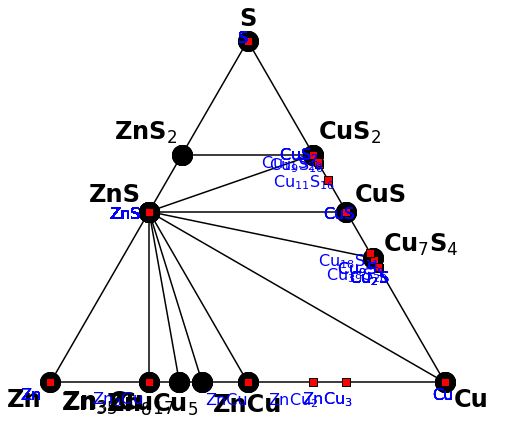

In [269]:
plotter = PDPlotter(phase_diagram, show_unstable=True, markersize=20)  # we increase the marker size here to make it easier to see the stable points
plotter.show()

#### Contour phase diagram

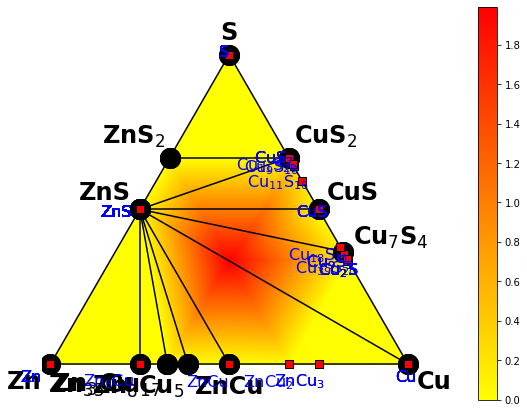

In [267]:
fig = plotter.get_contour_pd_plot()

#### Binary phase diagram

Let's zoom in on the tie-line between ZnS and CuS, which is where we are interested in alloying.

In [112]:
from pymatgen import Composition

In [113]:
cpd = CompoundPhaseDiagram(entries, [Composition("ZnS"), Composition("CuS")], normalize_terminal_compositions=False)

In [116]:
compound_plotter = PDPlotter(cpd, show_unstable=100, markersize=20)

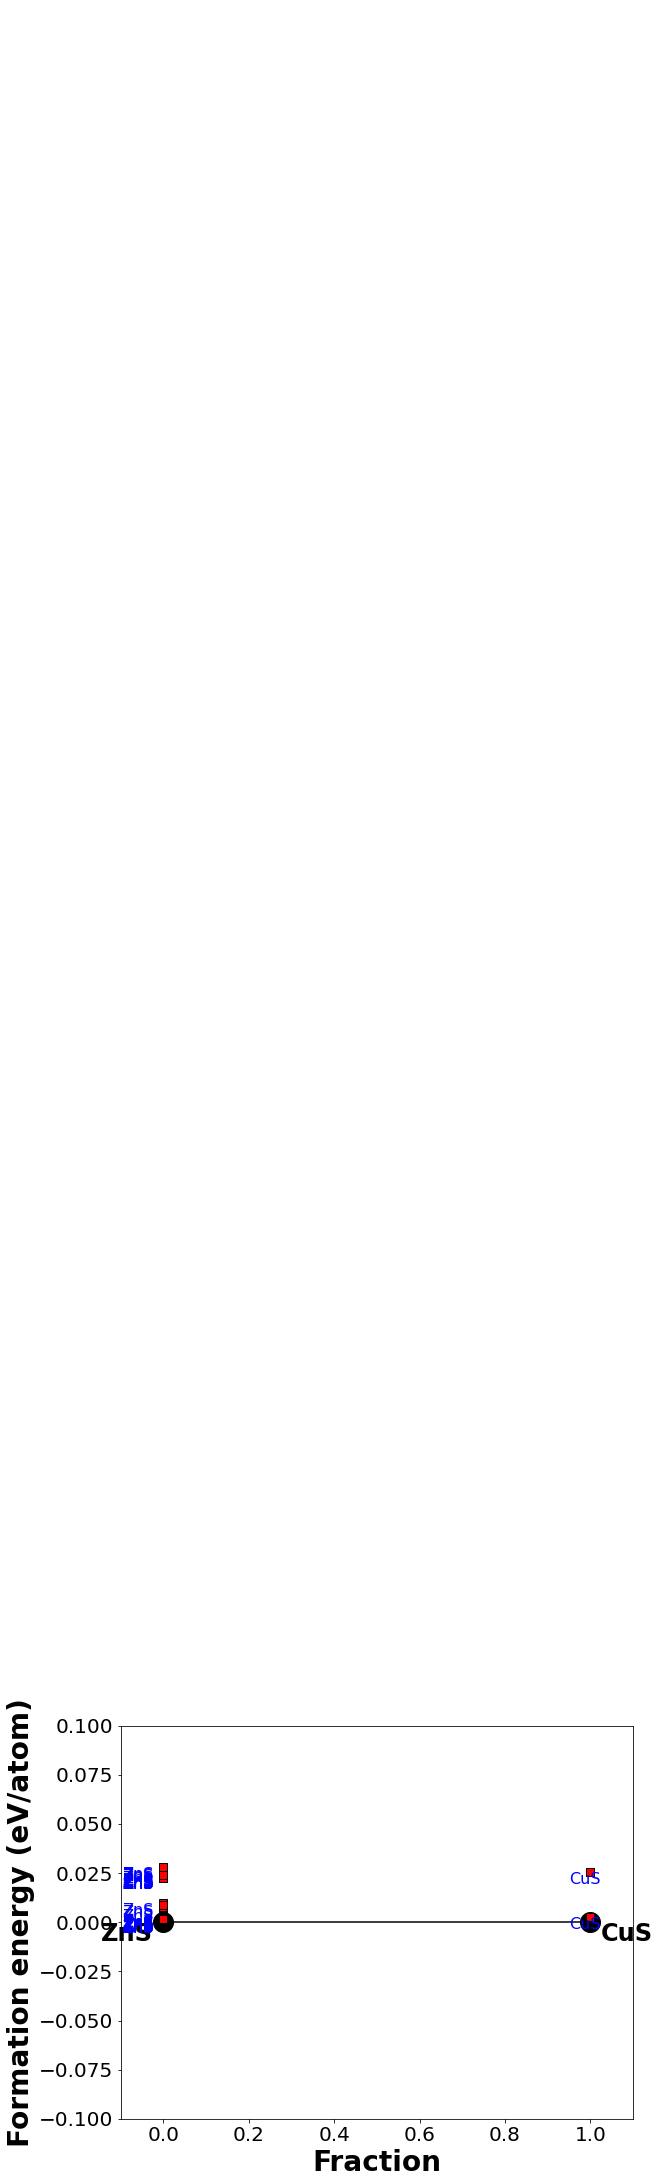

In [115]:
compound_plotter.show()

#### Mapping out chemical potential of cations

This may be a useful tool to think about tuning chemical potential for synthesis.

In [120]:
from pymatgen import Element

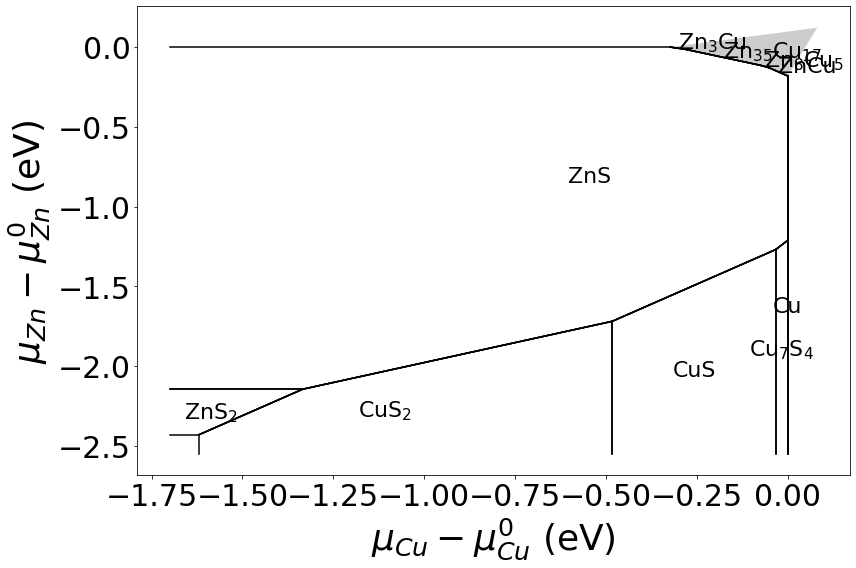

In [122]:
plotter.get_chempot_range_map_plot([Element("Cu"), Element("Zn")]).show()

There are a lot of different types of phase diagrams (see the [`pymatgen.analysis.phase_diagram` module](https://pymatgen.org/pymatgen.analysis.phase_diagram.html)).

Our key takeaway is that in MP, the Cu-Zn-S ternary space is EMPTY!! So let's fill it in...

## 3. Transform to make a new Cu<sub>x</sub>Zn<sub>1-x</sub>S alloy

### 3.1 Lesson: structure transformation

#### Substitute your dopant to create a disordered structure

Now, so let's substitute 1/4 of the Zn<sup>2+</sup> with Cu<sup>+</sup> ions (note: we will be ignoring charge compensation here, but this is important to take into account in real calculations!). That is, let's set substitutional fraction `x = 1/4` in Cu<sub>x</sub>Zn<sub>1-x</sub>S. Doing so using `Structure.replace_species()` will create a ***disordered structure object***.

In [128]:
x = 1/4

In [129]:
disordered_structure = ZnS_structure_oxi.copy()
disordered_structure.replace_species({"Zn2+": {"Cu+": x, "Zn2+": 1 - x}})

In [130]:
print(disordered_structure)

Full Formula (Zn0.75 Cu0.25 S1)
Reduced Formula: Zn0.75Cu0.25S1
abc   :   3.853923   3.853923   3.853923
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP                        a     b     c    magmom
---  ---------------------  ----  ----  ----  --------
  0  Zn2+:0.750, Cu+:0.250  0     0     0            0
  1  S2-                    0.25  0.25  0.25        -0


We can print the integer formula of this composition:

In [132]:
disordered_structure.composition

Comp: Zn0.75 Cu0.25 S1

Let's rename this structure with its chemical formula to avoid confusion later on:

In [133]:
CuZn3S4_disordered = disordered_structure

In [134]:
# if you want to download this file and load it on crystal toolkit

CuZn3S4_disordered.to("cif", "assets/CuZn3S4_disordered.cif")

Here's a screenshot of the CuZn<sub>3</sub>S<sub>4</sub> disordered structure, where each cation site has partial occupancy of a Zn and Cu atom. 

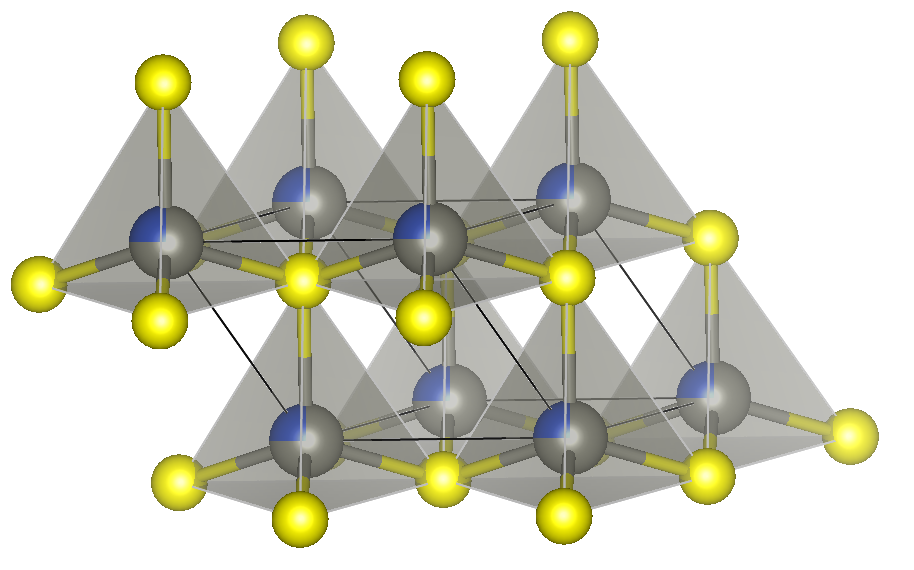

#### Transform structure

Though disorder may indeed be more representative of a real crystal structure, we need to convert this to an ordered structure to perform DFT calculations. This is because DFT can only perform simulations on whole atoms, not fractional atoms!

Pymatgen supports a variety of structural "transformations" (a list of supported transformations is available [here](https://pymatgen.org/pymatgen.transformations.html)). Here are three methods from the `pymatgen.transformations.advanced_transformations` module to take a disordered structure, and order it:

1. `OrderDisorderStructureTransformation`: a highly simplified method to create an ordered supercell ranked by Ewald sums.
2. `EnumerateStructureTransformation`: a method to order a disordered structure that requires [the `enumlib` code](https://github.com/msg-byu/enumlib) to also be installed.
3. `SQSTransformation`: a method that requires the [`ATAT` code (Van de Walle et al. 2013)](https://doi.org/10.1016/j.calphad.2013.06.006) to be installed that creates a special quasirandom structure (SQS) from a structure with partial occupancies.

For this demo, we'll be focusing on the most simple transformation: `OrderDisorderStructureTransformation`

In [140]:
from pymatgen.transformations.advanced_transformations import OrderDisorderedStructureTransformation

In [141]:
odst = OrderDisorderedStructureTransformation()

In [142]:
odst.apply_transformation(CuZn3S4_disordered)

Structure Summary
Lattice
    abc : 3.853922876297604 3.853922876297604 3.853922876297604
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 40.475671304233664
      A : 0.0 2.725135 2.725135
      B : 2.725135 0.0 2.725135
      C : 2.725135 2.725135 0.0
PeriodicSite: Zn2+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: S2- (1.3626, 1.3626, 1.3626) [0.2500, 0.2500, 0.2500]

We have to be careful though!! If we just apply this transformation, it doesn't fail, but it returns a structure where all the Cu<sup>+</sup> is gone! `OrderDisorderedStructureTransformation` will round up or down if the cell is not large enough to account for `x`. Thus, we need to first make a supercell and then apply the transformation.

#### Make a supercell

With this transformation, we have to first create a disordered ***supercell*** to transform into. A supercell is just a structure that is scaled by a matrix so that it repeats several times. Here, the supercell must be large enough such that the composition in question can be achieved.

Let's scale the structure by 8x. I like to use the `numpy` package to construct scaling matrices here (a 4x supercell would be sufficient for `x = 1/4`, but this leaves room to try e.g. `x = 1/8`):

In [143]:
import numpy as np

In [149]:
scaling_matrix = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 2]
])

We can see that this would scale the cell's volume by 8, but to verify:

In [282]:
scaling_volume = np.linalg.det(scaling_matrix)

For convenience, you can also simply use `scaling_matrix = 2` if you're scaling the same in all directions, or `scaling_matrix = [2, 2, 2]`. These are the same in practice.

In [153]:
CuZn3S4_disordered_supercell = CuZn3S4_disordered * scaling_matrix

In [154]:
print(CuZn3S4_disordered_supercell)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP                         a      b      c    magmom
---  ---------------------  -----  -----  -----  --------
  0  Zn2+:0.750, Cu+:0.250  0      0      0             0
  1  Zn2+:0.750, Cu+:0.250  0      0      0.5           0
  2  Zn2+:0.750, Cu+:0.250  0      0.5    0             0
  3  Zn2+:0.750, Cu+:0.250  0      0.5    0.5           0
  4  Zn2+:0.750, Cu+:0.250  0.5    0      0             0
  5  Zn2+:0.750, Cu+:0.250  0.5    0      0.5           0
  6  Zn2+:0.750, Cu+:0.250  0.5    0.5    0             0
  7  Zn2+:0.750, Cu+:0.250  0.5    0.5    0.5           0
  8  S2-                    0.125  0.125  0.125        -0
  9  S2-                    0.125  0.125  0.625        -0
 10  S2-                    0.125  0.625  0.125        -0
 11  S2-                    0.125  0.625  0.625        -0
 12  S2-                    0.625  0.125  0.

In [155]:
CuZn3S4_ordered_structures = odst.apply_transformation(CuZn3S4_disordered_supercell, return_ranked_list = 10)

In [160]:
print(CuZn3S4_ordered_structures)

[{'energy': -285.4743424481398, 'energy_above_minimum': 0.0, 'structure': Structure Summary
Lattice
    abc : 7.707845752595208 7.707845752595208 7.707845752595208
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 323.8053704338693
      A : 0.0 5.45027 5.45027
      B : 5.45027 0.0 5.45027
      C : 5.45027 5.45027 0.0
PeriodicSite: Zn2+ (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Zn2+ (2.7251, 0.0000, 2.7251) [0.0000, 0.5000, 0.0000]
PeriodicSite: Zn2+ (5.4503, 2.7251, 2.7251) [0.0000, 0.5000, 0.5000]
PeriodicSite: Zn2+ (0.0000, 2.7251, 2.7251) [0.5000, 0.0000, 0.0000]
PeriodicSite: Zn2+ (2.7251, 5.4503, 2.7251) [0.5000, 0.0000, 0.5000]
PeriodicSite: Zn2+ (5.4503, 5.4503, 5.4503) [0.5000, 0.5000, 0.5000]
PeriodicSite: Cu+ (2.7251, 2.7251, 0.0000) [0.0000, 0.0000, 0.5000]
PeriodicSite: Cu+ (2.7251, 2.7251, 5.4503) [0.5000, 0.5000, 0.0000]
PeriodicSite: S2- (1.3626, 1.3626, 1.3626) [0.1250, 0.1250, 0.1250]
PeriodicSite: S2- (4.0877, 4.0877, 1

This is a list of ten ordered structures ranked by ***Ewald sum*** (dict key `"energy"`). Note that this does NOT correlate with the lowest energy structure! Let's just use the first entry for our example:

In [161]:
CuZn3S4_ordered_structure = CuZn3S4_ordered_structures[0]["structure"]

In [162]:
print(CuZn3S4_ordered_structure)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0      0             0
  1  Zn2+  0      0.5    0             0
  2  Zn2+  0      0.5    0.5           0
  3  Zn2+  0.5    0      0             0
  4  Zn2+  0.5    0      0.5           0
  5  Zn2+  0.5    0.5    0.5           0
  6  Cu+   0      0      0.5           0
  7  Cu+   0.5    0.5    0             0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


If you want to download this file:

In [ ]:
CuZn3S4_ordered_structure.to("cif", "assets/CuZn3S4_ordered_structure.cif")

In [163]:
# (note: "-0" is actually just 0, as this is a non-magnetic configuration)

BOOM! Now we have an alloy structure!! To view this structure you can upload your "CuZn3S4_ordered_structure.cif" file on [Crystal Toolkit](https://materialsproject.org/#apps/xtaltoolkit).

<img src="assets/Zn3CuS4_P-43m_estimate.png" style="max-width:50%">

### 3.2 Exercise: try your own transformation on CuZnS<sub>2</sub>

Set a new composition, `x = 1/2` (simpler fractions are easier in DFT calculations because supercells can be smaller!). This will yield a structure with composition CuZnS<sub>2</sub>.

In [166]:
x_CuZnS2 = 1/2

In [168]:
CuZnS2_disordered = ZnS_structure_oxi.copy()
CuZnS2_disordered.replace_species(
    {
        "Zn2+": {
            "Cu+": x_CuZnS2,
            "Zn2+": 1 - x_CuZnS2
        }
    }
)

Reminder: for more complex fractions (e.g. `x = 1/16`), supercells need to be scaled accordingly!

In [169]:
scaling_matrix = np.array([2, 2, 2])

In [170]:
CuZnS2_disordered_supercell = CuZnS2_disordered * scaling_matrix

In [171]:
CuZnS2_ordered_structures = odst.apply_transformation(CuZnS2_disordered_supercell,
                                             return_ranked_list = 10)

Pick one:

In [172]:
CuZnS2_ordered_structure = CuZnS2_ordered_structures[0]["structure"]

In [173]:
print(CuZnS2_ordered_structure)

Full Formula (Zn4 Cu4 S8)
Reduced Formula: ZnCuS2
abc   :   7.707846   7.707846   7.707846
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0.5    0             0
  1  Zn2+  0      0.5    0.5           0
  2  Zn2+  0.5    0      0             0
  3  Zn2+  0.5    0      0.5           0
  4  Cu+   0      0      0             0
  5  Cu+   0      0      0.5           0
  6  Cu+   0.5    0.5    0             0
  7  Cu+   0.5    0.5    0.5           0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


Check that this is the composition you expect:

In [174]:
CuZnS2_ordered_structure.composition.reduced_formula

'ZnCuS2'

And check the space group:

In [175]:
CuZnS2_ordered_structure.get_space_group_info()

('P-4m2', 115)

Is it the same as ZnS? Because of the Cu substitution, this structure has a different space group than ZnS!

## 4. Calculate new properties

### 4.1 Lesson: volume prediction and XRD plot

So far we just have a really rough guess of an alloy structure, and the lattice parameters are still equal to those of ZnS. We can estimate the new volume $V_{x-guess}$ after the substitution using Vegard's Law (assuming zero bowing).

$V_{x-estimate} = V_{scaling } \times [ V_{CuS}(x) + V_{ZnS}(1-x) ] $

$V_{CuZn_3S_4-estimate} = [2\times2\times2] \times [ V_{CuS}(0.25) + V_{ZnS}(0.75) ] $

In [176]:
scaling_matrix

array([2, 2, 2])

In [177]:
x

0.25

In [178]:
scaling_volume = scaling_matrix.prod()

In [182]:
CuZn3S4_estimated_volume = scaling_volume * ((ZnS_structure.volume) * (1 - x) + 
                                            (CuS_structure.volume) * x)

In [183]:
print(CuZn3S4_ordered_structure.volume)

323.8053704338693


In [184]:
print(CuZn3S4_estimated_volume)

313.0468709398932


In [185]:
CuZn3S4_structure_estimate = CuZn3S4_ordered_structure.copy()
CuZn3S4_structure_estimate.scale_lattice(CuZn3S4_estimated_volume)

In [186]:
print(CuZn3S4_structure_estimate)

Full Formula (Zn6 Cu2 S8)
Reduced Formula: Zn3CuS4
abc   :   7.621518   7.621518   7.621518
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0      0             0
  1  Zn2+  0      0.5    0             0
  2  Zn2+  0      0.5    0.5           0
  3  Zn2+  0.5    0      0             0
  4  Zn2+  0.5    0      0.5           0
  5  Zn2+  0.5    0.5    0.5           0
  6  Cu+   0      0      0.5           0
  7  Cu+   0.5    0.5    0             0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


This is better but still wrong, and does not take into account any structural distortions. Note that there are some other methods on pymatgen to guess structure volume (see `pymatgen.analysis.structure_prediction.volume_predictor`), but in my experience Vegard's law is usually just as helpful. Your next step would be to relax this new structure using DFT or another method (see below).

#### Calculate XRD, compare to original structure

Now we can compare this structure to our original ZnS and CuS structure to, for example, see how the ***X-ray diffraction (XRD)*** patterns are expected to shift as `x` increases in Cu<sub>x</sub>Zn<sub>1-x</sub>S:

In [187]:
from pymatgen.analysis.diffraction.xrd import XRDCalculator

Initialize the `XRDCalculator` with the conventional Cu-K$\alpha$ wavelength (note: Cu here has nothing to do with the Cu we're adding to the structure):

In [259]:
xrd = XRDCalculator()

In [258]:
structures = [
    ZnS_structure, 
    CuZn3S4_structure_estimate, 
    CuS_structure
]

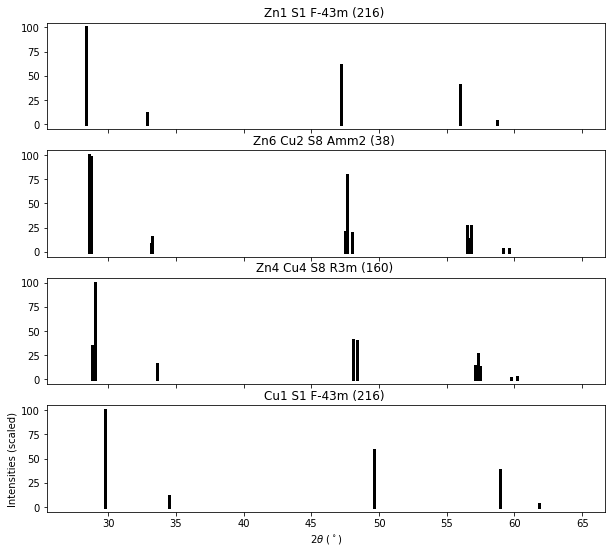

In [247]:
xrd_plots = xrd.plot_structures(
    structures,
    two_theta_range=[25, 65],
    annotate_peaks=False, # to keep the plot cleaner
    size_kwargs={'w': 10, 'h': 9}, # these options are optional to make the plot look nicer
)

You can see how the $2\theta$ peaks shift slightly to the right with addition of Cu!

### 4.2 Exercise: try this on your CuZnS<sub>2</sub> structure

Guess the structure volume using Vegard's Law, and correct for this:

$V_{x-estimate} = V_{scaling } \times [ V_{CuS}(?) + V_{ZnS}(?) ] $

In [198]:
x_CuZnS2

0.5

In [199]:
scaling_volume

8

In [200]:
CuZnS2_structure_estimate = CuZnS2_ordered_structure.copy()
CuZnS2_structure_estimate.scale_lattice(scaling_volume * 
                                          ((ZnS_structure.volume) * (1 - x_CuZnS2) + 
                                           (CuS_structure.volume) * x_CuZnS2))

Print the new structure

In [201]:
print(CuZnS2_structure_estimate)

Full Formula (Zn4 Cu4 S8)
Reduced Formula: ZnCuS2
abc   :   7.533188   7.533188   7.533188
angles:  60.000000  60.000000  60.000000
Sites (16)
  #  SP        a      b      c    magmom
---  ----  -----  -----  -----  --------
  0  Zn2+  0      0.5    0             0
  1  Zn2+  0      0.5    0.5           0
  2  Zn2+  0.5    0      0             0
  3  Zn2+  0.5    0      0.5           0
  4  Cu+   0      0      0             0
  5  Cu+   0      0      0.5           0
  6  Cu+   0.5    0.5    0             0
  7  Cu+   0.5    0.5    0.5           0
  8  S2-   0.125  0.125  0.125        -0
  9  S2-   0.125  0.125  0.625        -0
 10  S2-   0.125  0.625  0.125        -0
 11  S2-   0.125  0.625  0.625        -0
 12  S2-   0.625  0.125  0.125        -0
 13  S2-   0.625  0.125  0.625        -0
 14  S2-   0.625  0.625  0.125        -0
 15  S2-   0.625  0.625  0.625        -0


Add this structure to the series of XRD plots to compare XRD for `x = 0, 0.25, 0.5, 1`:

In [257]:
structures = [
    ZnS_structure, 
    CuZn3S4_structure_estimate, 
    CuZnS2_structure_estimate, 
    CuS_structure
]

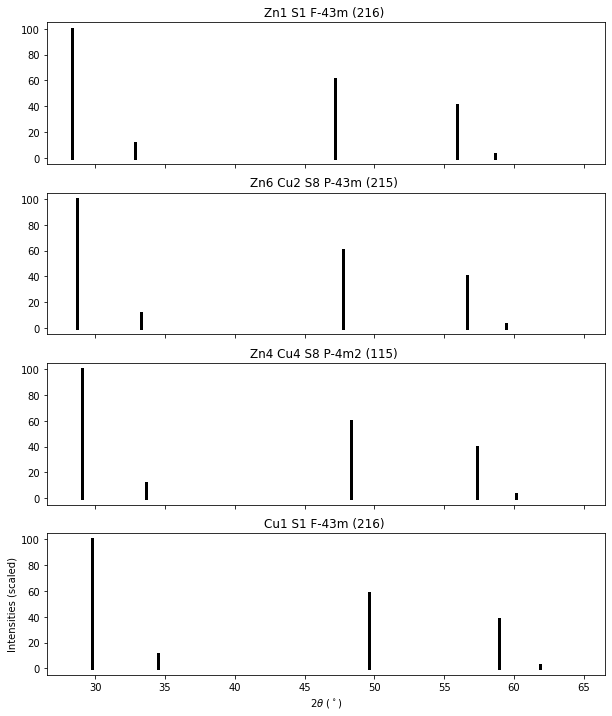

In [255]:
xrd_plots = xrd.plot_structures(
    structures,
    annotate_peaks=False,
    two_theta_range=[25,65],
    size_kwargs={'w': 10, 'h': 12}
)

## 5. Test your skills

This is the wee beginning of making an alloy. Here are some follow-up steps:

<img src="assets/next_steps.png" style="max-width:60%">

I constructed similar alloys to those that we just explored, at `x = 1/4` and `x = 1/2`, and relaxed them with DFT. We'll explore my results here:

### 5.1 Exercise: compare relaxed DFT structures to estimates

In [204]:
from pymatgen import Structure

These are my output .cif files from one of our DFT workflows. See `fireworks` and `atomate` packages for details [here](https://atomate.org/atomate.vasp.fireworks.html).

In [205]:
CuZn3S4_relaxed = Structure.from_file("assets/Zn3CuS4_Amm2.cif")
CuZnS2_relaxed = Structure.from_file("assets/ZnCuS2_R3m.cif")

#### How do these space groups compare to our estimates?

In [206]:
CuZn3S4_structure_estimate.get_space_group_info()

('P-43m', 215)

In [207]:
CuZn3S4_relaxed.get_space_group_info()

('Amm2', 38)

In [208]:
CuZnS2_structure_estimate.get_space_group_info()

('P-4m2', 115)

In [209]:
CuZnS2_relaxed.get_space_group_info()

('R3m', 160)

Are they higher or lower in symmetry? After relaxation, both structures are in a different space group (lower symmetry) than the alloys we just made. This is likely due to structural distortions.

#### Add in DFT structure to XRD

Replace the alloy structures in the previous XRD exercise with the two relaxed alloy structures, again comparing XRD for `x = 0, 0.25, 0.5, 1`:

In [243]:
structures = [
    ZnS_structure,
    CuZn3S4_relaxed,
    CuZnS2_relaxed,
    CuS_structure
 ]

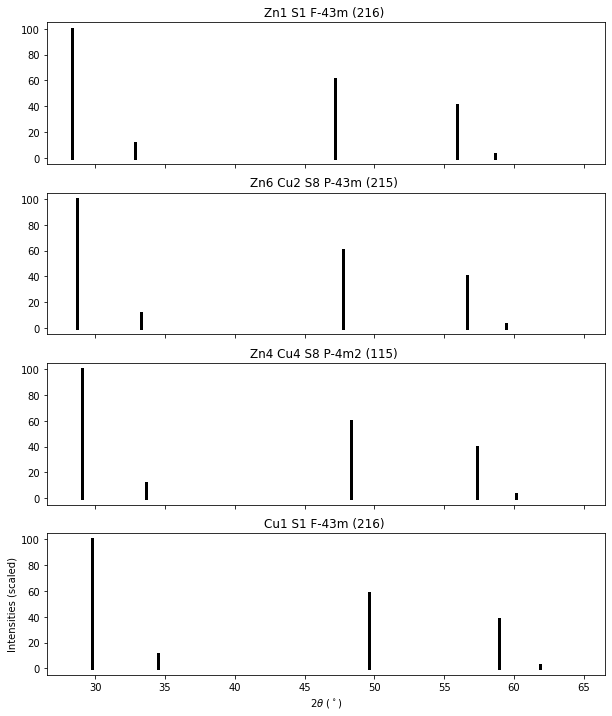

In [251]:
xrd_plots = xrd.plot_structures(
    structures, 
    annotate_peaks=False,
    two_theta_range=[25,65],
    size_kwargs={'w': 10, 'h': 12},
)

Peak splittings are now present in the diffraction patterns, and the shift to higher $2\theta$ is not as significant.

### 5.2 Lesson: add computed entries to phase diagram

***Scientific question: are these new phases stable?***

To assess the stability of these new phases, let's look at JSON files containing `ComputedEntry` data:

In [217]:
from monty.serialization import loadfn

In [218]:
Zn3CuS4_Amm2_entry = loadfn("assets/Zn3CuS4_Amm2_entry.json")
ZnCuS2_R3m_entry = loadfn("assets/ZnCuS2_R3m_entry.json")

These entries were created by relaxing the above structure using one of our DFT workflows. An "entry" is mainly just a composition and an energy, so can be created manually, without performing a calculation, or even from experimental data

In [229]:
print(ZnCuS2_R3m_entry)

None ComputedEntry - Zn1 Cu1 S2   (ZnCuS2)
Energy (Uncorrected)     = -61.8816  eV (-15.4704 eV/atom)
Correction               = -1.3269   eV (-0.3317  eV/atom)
Energy (Final)           = -63.2085  eV (-15.8021 eV/atom)
Energy Adjustments:
  MP Gas Correction      : 0.0000    eV (0.0000   eV/atom)
  MP Anion Correction    : -1.3269   eV (-0.3317  eV/atom)
  MP Advanced Correction : 0.0000    eV (0.0000   eV/atom)
Parameters:
  run_type               = GGA
  is_hubbard             = False
Data:


We can add these two entries to `entries`, our set of `ComputedEntry` data from MP in the Cu-Zn-S phase space:

In [232]:
new_entries = entries + [Zn3CuS4_Amm2_entry, ZnCuS2_R3m_entry]

In [233]:
new_phase_diagram = PhaseDiagram(new_entries)

#### Conventional phase diagram

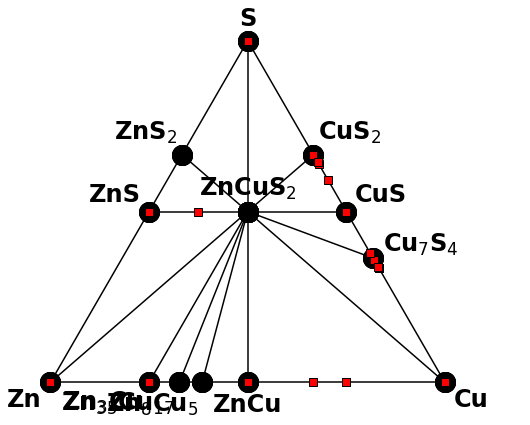

In [270]:
new_plotter = PDPlotter(new_phase_diagram, show_unstable=10, markersize=20)
x = new_plotter.get_plot(new_phase_diagram, label_unstable=False)

We see our two new phases show up here! How does the energy landscape change?

#### Contour phase diagram

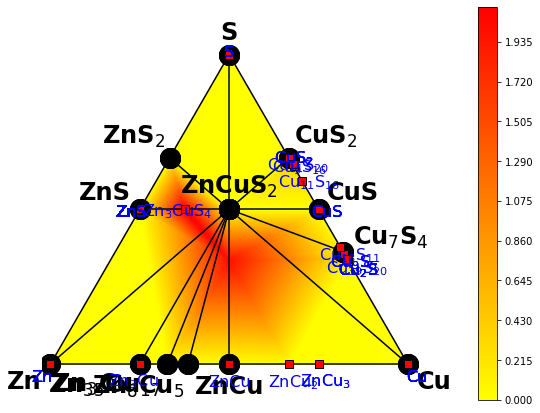

In [279]:
new_fig = new_plotter.get_contour_pd_plot()

Compare to the phase diagram before new phases were added:

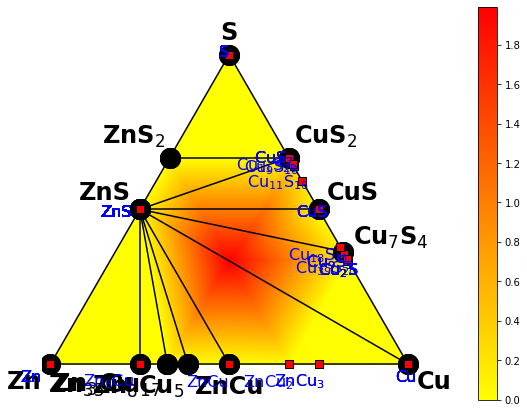

In [280]:
fig = plotter.get_contour_pd_plot()

#### Binary phase diagram

In [236]:
from pymatgen import Composition

In [237]:
new_cpd = CompoundPhaseDiagram(new_entries, [Composition("ZnS"), Composition("CuS")])

In [238]:
new_compound_plotter = PDPlotter(new_cpd, show_unstable=10, markersize=20)

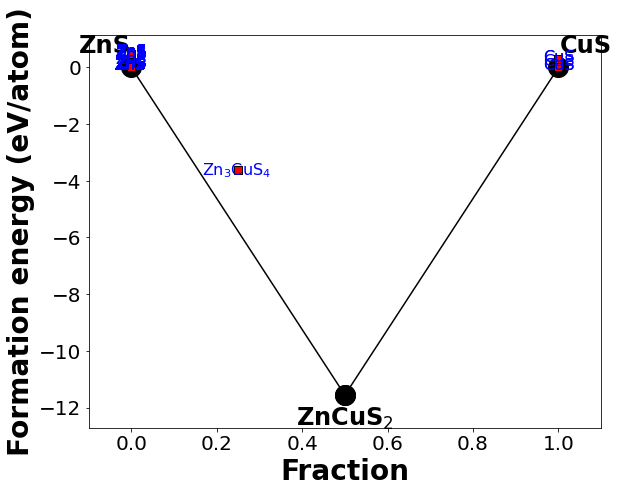

In [239]:
new_compound_plotter.show()

In [256]:
new_phase_diagram.get_e_above_hull(ZnCuS2_R3m_entry)

0

In [240]:
new_phase_diagram.get_e_above_hull(Zn3CuS4_Amm2_entry)

2.147880326428571

Because these phases break the binary hull, this shows that there is likely a stable phase of CuZnS<sub>2</sub>, though this may not be the lowest energy phase. Zn<sub>3</sub>CuS<sub>4</sub> is highly metastable.

### 5.3 Next steps

Here are some follow-up calculations you can do to explore ternary space:

* ***Structure Prediction***: To explore other possibilities of polymorphs in Cu-Zn-S ternary space, one could perform a "structure prediction" in this chemical space. You can use the Materials Project website's [Structure Prediction app](https://materialsproject.org/#apps/structurepredictor). There are also methods in `pymatgen.analysis.structure_prediction` to do this.
* ***DFT Calculations***: You can submit your structure(s) to MP by loading it with the [Crystal Toolkit app](https://materialsproject.org/#apps/crystaltoolkit) and clicking "Submit to Materials Project". You can use `fireworks` and `atomate` to submit DFT calculations yourself to relax the structure, refine it, calculate band structure, and other properties.
* ***Local Environment Analysis***: With your relaxed structures, you can upload your structure to the [Crystal Toolkit app](https://materialsproject.org/#apps/crystaltoolkit) and look at "Analyze: Local Environments" to compare coordination environments. You can also explore the features in `pymatgen.analysis.local_env`.
* ***Substrate Matcher***: If you want to grow this alloy structure epitaxially, you can explore different substrates to use on the website using methods in `pymatgen.analysis.substrate_analyzer module`.

### Thank you! Feel free to reach me at rwoodsrobinson@lbl.gov if you have any questions about this lesson.